In [9]:
import numpy as np
import tensorflow as tf
import utils, imp
from functools import partial

Before we use any sentiment training, it might be worth exploring, which words are in any way determining labels. There are more than 70k words, so learning matrices capable of processing vectors that huge is going to take forever. Most of them is going be not so informative - for instance, words like 'I', 'the', 'will', 'be', 'want' are most likely going to occur in every label with roughly the same probability. 

What I will want to find, will be how distributions of joint probability $P( W, L )$ diverges from independence assumptions $P( W, L ) = P(W)P(L)$. 

What models am I going to build? First one will be simple Naive Bayes. I will test for occurence of given word, its count and Tf-Idf score. I will use CountVectorizer and TfidfVectorizer from sci-kit learn package. Moreover, using vectors given by these models as inputs, I will build simple logistic regression and neural network with one hidden layer. Another model I'm curious to check out would be average over word embeddings in sentence. At last, I will reach recurrent neural networks, which I expect to explore more deeply.

Due to desire to keep this notebook somewhat clean and readable, I'm storing both all of my helper functions and models in separate files. I will try to explain what is going on, but they are easily checkable.

In [12]:
dataset = utils.load_data(keywords=['technology', 'design', 'entertainment'])

#it loads and shuffles my training data from TED dataset. Here used with default parameters. Under the hood, it also
#does some basic preprocessing - turns to lowercase, deletes numbers and diactric signs

X, y = list(zip(*dataset))
y, labels_readable = utils.transform_labels_usable(y)

In [13]:
data = X, y

In [14]:
counts = np.unique(y, return_counts=True)[1]

Classes are highly imbalanced. This is going to be a problem.

I'm going to need some plotting device. Matplotlib is indispensable.

In [10]:
import matplotlib.pyplot as plt

In order to determine most useful words, I will need some metric of difference between two distributions of probability - first one being proportional to labels' frequency in dataset and other one conditioned by word. There are two common ways to do this - first one is called mutual information score, second is Chi-Squared test. 

$$ MI = \sum_{w_i \in W} \sum_{l_j \in L} P( w = w_i, l = l_j ) \log \frac{P( w = w_i, l = l_j )}{P( w = w_i) P(l = l_j)} $$

Those of you familiar with statistics can recognize this as cross entropy - basically we are testing how different our joint distribution is from distributions that holds independence assumption.

Chi-Squared test also tests this difference, but with more straightforward way.

$$ \tilde{\chi}^2 = \sum_{w_i \in W} \sum_{l_j \in L} \frac{\left( N_{ w_i, l_j} - E_{  w_i, l_j } \right)^2}{E_{ w_i, l_j }}$$

where $N_{ w = w_i, l = l_j}$ is number of real occurences of both word and label and $E_{ w = w_i, l = l_j }$ is number of occurence should these two factors were independent. $\tilde{\chi}^2$ is probability distribution - if it is in 

Fortunately, I don't have to write this pretty straightforward functions myself - sci-kit learn package is going to do all tedious processing.

In [6]:
from sklearn.feature_selection import chi2, mutual_info_classif

First things first, I can't really use all the words. Many of them occurs only once, so it would be basically relying on chance. I have to assert that every $P( w = w_i, l = l_j )$ is greater than zero, at the very least.

In [15]:
word_counts = utils.count_words(X)

In [18]:
proportions_dict = utils.calculate_probs_occurence(word_counts.keys(), X, y)

Let's check number of words fulfilling the condition of having at least 20 occurences in every class. Apart from that, I will test for showing up in at least ten percent of documents.

In [19]:
perc_threshold = int(len(X)/10)
occ_threshold = 20

In [20]:
at_least_occ = list(filter(lambda x: np.all(proportions_dict[x] > occ_threshold), proportions_dict.keys()))
at_least_threshold = list(filter(lambda x: np.sum(proportions_dict[x])>perc_threshold, proportions_dict.keys()))

In [21]:
len(at_least_occ)

66

Well, that was unexpected

In [22]:
len(at_least_threshold)

1106

In [23]:
at_least_5 = list(filter(lambda x: np.all(proportions_dict[x]>5), proportions_dict.keys()))

In [24]:
len(at_least_5)

419

All in all, everything will be determined be final score of the estimator - maybe someone more skilled in statistics would be able to predict, which approach is going to yield better accuracy of predictions? Before I get around to testing predictors, it's time to check how these sets encapsulate each other.

In [25]:
len(set(at_least_threshold) - set(at_least_5))

687

Before I do any feature engineering, let's check how simple models are going to perform on last two sets of words. I will use three vectorizers and three different models, respectively. Binary count vectorizer will select features for Bernoulli Naive Bayes ( further NB ), ordinary count vectorizer will produce inputs for Multinomial NB and tf-idf vectorizer will fabricate samples for Gaussian NB.

What do I mean by text vectorizer? Well, it is simply function that takes some given sequence of words as input and outputs some vector of numbers - be it integers or reals. For instance, for dictionary of words of size $N$, vectorizer will output vector of size $N$. Number on $i$-th position will be representing frequency, occurence (or lack thereof) of $i$-th word. In binary vectorizer, it will be 1 if word was found in given text and zero otherwise. In count vectorizer, it is going be number of times word was found in text. Misterious tf-idf vectorizer will return number produced by equation: $\frac{\#w_{ji}}{\#w_j} \cdot \frac{N}{\log 1 + D_{w_i} }$, where $w_j$ denotes number of words in document, $w_{ji}$ number of times word $w_i$ can be found in $D_j$ and $D_{w_i}$ is number of documents which one can find $w_i$ in.

In [7]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score

I've decided to import accuracy_score only for brevity - displaying confusion matrix, while useful, is going to take up a lot of place in this notebook. It would be reasonable for one classifier, but not for six of them (two vocab sets, three models ). Since this is multiclass problem, I can't really use other metrics such as precision and recall out of the box - I would have to turn this into multiple binary classification problems.

In [17]:
BinaryVectorizer = partial(CountVectorizer, binary=True)

I track metrics for both training and test sets. Therefore I will be capable of measuring overfitting and gain another way to better my models.

In [18]:
imp.reload(utils)

overall_scores = []
vect_model = list(zip([BinaryVectorizer, CountVectorizer, TfidfVectorizer],[BernoulliNB, MultinomialNB, GaussianNB]))
for vocab in [at_least_5, at_least_threshold]:
    
    for i in range(3):
        
        vectorizer, model = vect_model[i]
        params = {
            'vectorizer':vectorizer,
            'model':model,
            'vocabulary':vocab,
            'data':data
        }
        
        score, pip = utils.train_test_pipeline(**params)
        overall_scores.append(score)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarnin

In [19]:
from sklearn.model_selection import cross_val_score

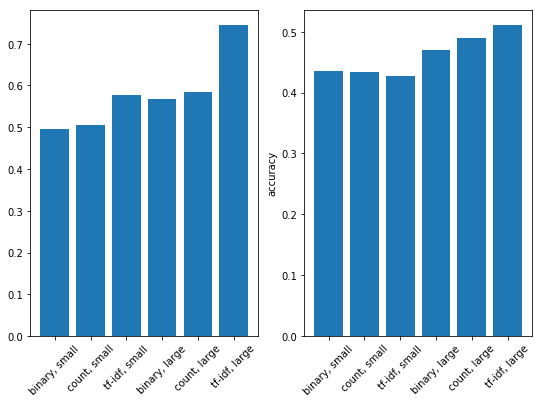

In [20]:
xticks = ['{model}, {vocab}'.format(model=model, vocab=vocab) for vocab in ['small', 'large'] for model in ['binary', 'count', 'tf-idf']]

plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.bar(range(1,7), [x[0]['accuracy'] for x in overall_scores])
plt.xticks(range(1,7), xticks, rotation=45)
plt.subplot(1,2,2)
plt.bar(range(1,7), [x[1]['accuracy'] for x in overall_scores])
plt.xticks(range(1,7), xticks, rotation=45)
plt.ylabel('accuracy')
plt.show()

In [21]:
score, pip = utils.train_test_pipeline(vectorizer=BinaryVectorizer, model=MultinomialNB, vocabulary=at_least_threshold, data=data)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarnin

In [22]:
score, pip

([{'accuracy': 0.65329257536600815,
   'log loss': 1.8817345211102008,
   'precision': 0.68833850156391274,
   'recall': 0.74893345470518236},
  {'accuracy': 0.52135092178113118,
   'log loss': 3.242976684353831,
   'precision': 0.31550007626286741,
   'recall': 0.32887180956184559}],
 Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
    ...     validate=True)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]))

Unexpected winner

As one might easily see, these models are clearly overfit. Since NB classifiers do not have any parameteres, there is not very much to tune here. I might, however, try constructing some ensembles. I will take best-performing model and train couple of its versions. 

I will split training set into N folds and train n-th model on every fold except n-th one. Then I will average their predictions on test set.

In [46]:
imp.reload(utils)

<module 'utils' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/utils.py'>

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [30]:
train_data = x_train, y_train

Unfortunately, I can't test this approach on more than 18 folds since least populated class has that many samples. It will have to wait until I test multiclass binary approach

In [48]:

pip = utils._create_vect_pipeline(vectorizer=BinaryVectorizer, 
                                  model=MultinomialNB, 
                                  vocabulary=at_least_threshold)

pips = utils.train_models_on_folds(pip, x_train, y_train, number=10)
train_scores = utils.many_models_score(pips, x_train, y_train)
test_scores = utils.many_models_score(pips, x_test, y_test)
    
   

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
print(train_scores['log loss'], test_scores['log loss'])

1.59499246472 2.97582430756


In [50]:
train_scores, test_scores

({'accuracy': 0.68458093410108767,
  'log loss': 1.5949924647164873,
  'precision': 0.73663425932157334,
  'recall': 0.79187337664205204},
 {'accuracy': 0.55938697318007657,
  'log loss': 2.9758243075639488,
  'precision': 0.34313240167318559,
  'recall': 0.34328468127760337})

In [20]:
from sklearn.metrics import precision_score, recall_score

Not very impressive - we see that rare classes were rarely ( mostly not at all ) correctly labeled.

In [28]:
transfm = pip.transform(x_train)

In [29]:
transfm_test = pip.transform(x_test)

In [30]:
clf = MultinomialNB()

In [31]:
clf.fit(transfm, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [25]:
from sklearn.metrics import precision_score, recall_score

In [33]:
utils.test_score_one_vs_all(y_test, clf.predict(transfm_test), precision_score)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


array([ 0.77375566,  0.38636364,  0.36585366,  0.        ,  0.46666667,
        0.        ,  0.20408163,  1.        ])

In [34]:
rec = utils.test_score_one_vs_all(y_test, clf.predict(transfm_test), recall_score)

In [35]:
labels_readable[0] = 'none'

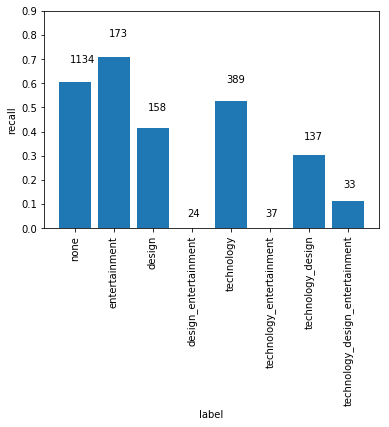

In [36]:
rects = plt.bar(range(1,9), rec)
for i, rect in enumerate(rects):
    h = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/3, .05*(1-h)+1.1*h, counts[i])

plt.xticks(range(1,9), labels_readable, rotation=90)
plt.ylim(0, .9)
plt.ylabel('recall')
plt.xlabel('label')
plt.show()



Finally, it's time to select best features, so I can be honest while comparing scores of different classifiers. It would not be very wise to give verdict "Naive Bayes is crap" while not taking elementary steps to make it a little bit better.

I'll start off with MIS. Also, since this is neither production-level analysis nor Kaggle contest, I will use only two best-performing models from previous pipeline - which means Multinomial Naive Bayes on top of Binary Vectorizer and Gaussian NB on top of Tf-idf. It does not mean, of course, that some other model would not outperform this one with less number of irrelevant words, but this ain't Kaggle competition ;)

In [53]:
imp.reload(utils)

overall_scores = []
pips = []
for k in range(10, 100, 10):
    
    score, pip = utils.feature_selection_pipeline(BinaryVectorizer, MultinomialNB, data, mutual_info_classif, 
                                                  vocabulary=at_least_threshold, k=k)
    
    overall_scores.append(score)
    pips.append(pip)
    
    print(k, score[0]['log loss'], score[1]['log loss'])

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


10 1.28485698057 1.30455723194


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


20 1.20892111271 1.25459474154


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


30 1.21288659697 1.27121281776


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


40 1.13483916086 1.22040542245


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


50 1.12009129696 1.21680426683


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


60 1.09353984485 1.20407611543


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


70 1.08722886573 1.22883500209


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


80 1.02058500422 1.17160784256
90 1.01281652831 1.18308755583


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
alt_scores = []
alt_pips = []
for k in range(10, 100, 10):
    
    score, pip = utils.feature_selection_pipeline(BinaryVectorizer, MultinomialNB, data, chi2, 
                                                  vocabulary=at_least_threshold, k=k)
    
    alt_scores.append(score)
    alt_pips.append(pip)
    
    print(k, score[0]['log loss'], score[1]['log loss'])

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


10 1.33887148774 1.35998631375


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


20 1.19148678342 1.23527857185


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


30 1.14047822693 1.20688274698


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


40 1.10454642827 1.19115358102


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


50 1.07989275548 1.18606829222


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


60 1.07411801902 1.19581975428


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


70 1.07629829355 1.21849959883


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


80 1.06309031778 1.22290805163
90 1.07067434938 1.24783399058


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [57]:
alt_scores = alt_scores[:len(overall_scores)]
alt_pips = alt_pips[:len(overall_scores)]

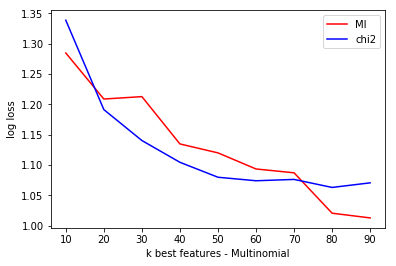

In [59]:
plt.figure(figsize=(6,4))
plt.plot(range(10, 100, 10), [x[0]['log loss'] for x in overall_scores], label='MI', c='red')
plt.plot(range(10, 100, 10), [x[0]['log loss'] for x in alt_scores], label='chi2', c='blue')
plt.xlabel('k best features - Multinomial')
plt.ylabel('log loss')
plt.legend(loc='best')
plt.show()

In [78]:
pips[-1].named_steps['countvectorizer'].get_feature_names()

['learned',
 'looked',
 'asking',
 'started',
 'built',
 'central',
 'measure',
 'havent',
 'world',
 'grew',
 'fine',
 'feel',
 'makes',
 'meant',
 'amount',
 'so',
 'forms',
 'begin',
 'ask',
 'major',
 'boy',
 'tiny',
 'across',
 'deal',
 'hundred',
 'loved',
 'falsenumber',
 'pick',
 'remember',
 'theyll',
 'involved',
 'hard',
 'cool',
 'sitting',
 'particular',
 'mostly',
 'range',
 'brought',
 'into',
 'movement',
 'somehow',
 'front',
 'human',
 'changing',
 'seemed',
 'therefore',
 'maybe',
 'enough',
 'living',
 'doing',
 'then',
 'state',
 'yes',
 'act',
 'war',
 'watching',
 'born',
 'though',
 'she',
 'species',
 'size',
 'serious',
 'take',
 'systems',
 'arent',
 'love',
 'several',
 'starts',
 'they',
 'youd',
 'were',
 'yourself',
 'plan',
 'met',
 'became',
 'twice',
 'humans',
 'months',
 'explain',
 'phone',
 'think',
 'moved',
 'house',
 'am',
 'internet',
 'projects',
 'thinking',
 'week',
 'available',
 'pay',
 'decided',
 'their',
 'soon',
 'of',
 'cities',
 'all

In [84]:
best_words = [pips[-1].named_steps['countvectorizer'].get_feature_names()[i] for i in range(len(at_least_threshold)) if pips[-1].named_steps['selectkbest'].get_support()[i]]

Sanity check

In [85]:
utils.train_test_pipeline(BinaryVectorizer, MultinomialNB, data, best_words)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarnin

([{'accuracy': 0.62355433738185284,
   'log loss': 1.0128165283099013,
   'precision': 0.55840283756829656,
   'recall': 0.35837939133718832},
  {'accuracy': 0.58362623852450746,
   'log loss': 1.1830875558336831,
   'precision': 0.2896167721056454,
   'recall': 0.24046710847673719}],
 Pipeline(steps=[('countvectorizer', CountVectorizer(analyzer='word', binary=True, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
    ...     validate=True)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]))

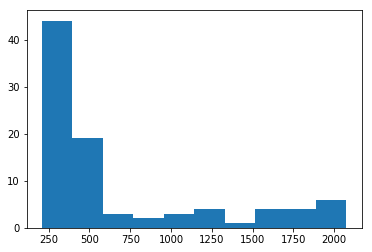

In [89]:
plt.hist([word_counts[word] for word in best_words])
plt.show()

In [99]:
worst_words = [pips[-1].named_steps['countvectorizer'].get_feature_names()[x] for x in np.argsort(pips[-1].named_steps['selectkbest'].scores_)[:100]]

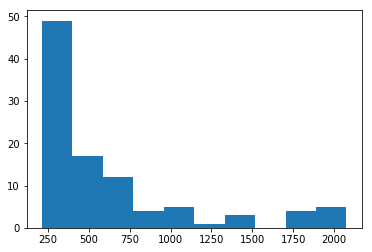

In [100]:
plt.hist([word_counts[word] for word in worst_words])
plt.show()

So it does not matter that much. 

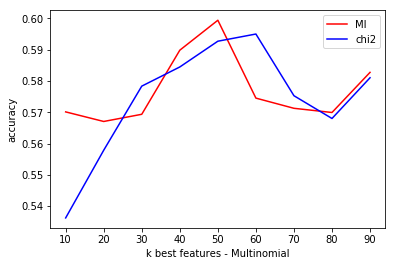

In [40]:
plt.figure(figsize=(6,4))
plt.plot(range(10, 100, 10), [x['accuracy'] for x in overall_scores], label='MI', c='red')
plt.plot(range(10, 100, 10), [x['accuracy'] for x in alt_scores], label='chi2', c='blue')
plt.xlabel('k best features - Multinomial')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from scipy.stats import uniform, randint

In [24]:
score, pip = utils.train_test_pipeline(TfidfVectorizer, LogisticRegression, data, at_least_threshold, 
                                       class_weight='balanced', C=5, penalty='l1')

KeyboardInterrupt: 

In [104]:
from sklearn.pipeline import make_pipeline, Pipeline

In [105]:
vect = TfidfVectorizer(vocabulary=at_least_threshold)
selector = SelectKBest(chi2)
lr = LogisticRegression()

pip = Pipeline([('vect', vect), ('sel', selector), ('lr', lr)])

In [92]:
searcher = RandomizedSearchCV(pip, 
                              n_iter=30, 
                              param_distributions={'sel__k': randint(5, 100), 'lr__C':uniform(1,10), 'lr__penalty': ['l1', 'l2']}, 
                              verbose=2, n_jobs=10, cv=10)

In [93]:
searcher.fit(X, y)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
[CV] sel__k=7, lr__penalty=l1, lr__C=8.2733851135 ....................
[CV] sel__k=7, lr__penalty=l1, lr__C=8.2733851135 ....................
[CV] sel__k=7, lr__penalty=l1, lr__C=8.2733851135 ....................
[CV] sel__k=7, lr__penalty=l1, lr__C=8.2733851135 ....................
[CV] sel__k=7, lr__penalty=l1, lr__C=8.2733851135 ....................
[CV] sel__k=7, lr__penalty=l1, lr__C=8.2733851135 ....................
[CV] sel__k=7, lr__penalty=l1, lr__C=8.2733851135 ....................
[CV] sel__k=7, lr__penalty=l1, lr__C=8.2733851135 ....................
[CV] sel__k=7, lr__penalty=l1, lr__C=8.2733851135 ....................
[CV] sel__k=7, lr__penalty=l1, lr__C=8.2733851135 ....................
[CV] ..... sel__k=7, lr__penalty=l1, lr__C=8.2733851135, total=  11.5s
[CV] sel__k=35, lr__penalty=l1, lr__C=10.2928174126 ..................
[CV] ..... sel__k=7, lr__penalty=l1, lr__C=8.2733851135, total=  11.8s
[CV] sel__k=35

[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:  1.2min


[CV] ... sel__k=23, lr__penalty=l2, lr__C=9.50734001605, total=  14.2s
[CV] sel__k=84, lr__penalty=l1, lr__C=7.75902323336 ..................
[CV] ... sel__k=23, lr__penalty=l2, lr__C=9.50734001605, total=  14.1s
[CV] sel__k=84, lr__penalty=l1, lr__C=7.75902323336 ..................
[CV] ... sel__k=23, lr__penalty=l2, lr__C=9.50734001605, total=  14.9s
[CV] sel__k=84, lr__penalty=l1, lr__C=7.75902323336 ..................
[CV] ... sel__k=23, lr__penalty=l2, lr__C=9.50734001605, total=  15.6s
[CV] sel__k=84, lr__penalty=l1, lr__C=7.75902323336 ..................
[CV] ... sel__k=23, lr__penalty=l2, lr__C=9.50734001605, total=  15.8s
[CV] sel__k=84, lr__penalty=l1, lr__C=7.75902323336 ..................
[CV] ... sel__k=23, lr__penalty=l2, lr__C=9.50734001605, total=  14.8s
[CV] sel__k=84, lr__penalty=l1, lr__C=7.75902323336 ..................
[CV] ... sel__k=23, lr__penalty=l2, lr__C=9.50734001605, total=  15.3s
[CV] sel__k=84, lr__penalty=l1, lr__C=7.75902323336 ..................
[CV] .

[CV] ... sel__k=14, lr__penalty=l1, lr__C=5.22278293793, total=  12.5s
[CV] sel__k=57, lr__penalty=l2, lr__C=6.08195434381 ..................
[CV] ... sel__k=57, lr__penalty=l2, lr__C=6.08195434381, total=  13.0s
[CV] sel__k=90, lr__penalty=l1, lr__C=3.76673712307 ..................
[CV] ... sel__k=57, lr__penalty=l2, lr__C=6.08195434381, total=  13.4s
[CV] sel__k=90, lr__penalty=l1, lr__C=3.76673712307 ..................
[CV] ... sel__k=57, lr__penalty=l2, lr__C=6.08195434381, total=  12.8s
[CV] sel__k=90, lr__penalty=l1, lr__C=3.76673712307 ..................
[CV] ... sel__k=57, lr__penalty=l2, lr__C=6.08195434381, total=  13.1s
[CV] sel__k=90, lr__penalty=l1, lr__C=3.76673712307 ..................
[CV] ... sel__k=57, lr__penalty=l2, lr__C=6.08195434381, total=  13.6s
[CV] sel__k=90, lr__penalty=l1, lr__C=3.76673712307 ..................
[CV] ... sel__k=57, lr__penalty=l2, lr__C=6.08195434381, total=  13.8s
[CV] sel__k=90, lr__penalty=l1, lr__C=3.76673712307 ..................
[CV] .

[CV] ... sel__k=10, lr__penalty=l1, lr__C=10.5242228049, total=  14.2s
[CV] sel__k=86, lr__penalty=l1, lr__C=10.7139282322 ..................
[CV] ... sel__k=10, lr__penalty=l1, lr__C=10.5242228049, total=  15.7s
[CV] sel__k=86, lr__penalty=l1, lr__C=10.7139282322 ..................
[CV] ... sel__k=10, lr__penalty=l1, lr__C=10.5242228049, total=  14.4s
[CV] sel__k=86, lr__penalty=l1, lr__C=10.7139282322 ..................
[CV] ... sel__k=86, lr__penalty=l1, lr__C=10.7139282322, total=  13.6s
[CV] sel__k=26, lr__penalty=l2, lr__C=3.23995917628 ..................
[CV] ... sel__k=86, lr__penalty=l1, lr__C=10.7139282322, total=  14.6s
[CV] ... sel__k=86, lr__penalty=l1, lr__C=10.7139282322, total=  15.1s
[CV] sel__k=26, lr__penalty=l2, lr__C=3.23995917628 ..................
[CV] sel__k=26, lr__penalty=l2, lr__C=3.23995917628 ..................


[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:  6.4min


[CV] ... sel__k=86, lr__penalty=l1, lr__C=10.7139282322, total=  14.4s
[CV] ... sel__k=86, lr__penalty=l1, lr__C=10.7139282322, total=  13.7s
[CV] ... sel__k=86, lr__penalty=l1, lr__C=10.7139282322, total=  13.7s
[CV] sel__k=26, lr__penalty=l2, lr__C=3.23995917628 ..................
[CV] sel__k=26, lr__penalty=l2, lr__C=3.23995917628 ..................
[CV] sel__k=26, lr__penalty=l2, lr__C=3.23995917628 ..................
[CV] ... sel__k=86, lr__penalty=l1, lr__C=10.7139282322, total=  14.8s
[CV] sel__k=26, lr__penalty=l2, lr__C=3.23995917628 ..................
[CV] ... sel__k=86, lr__penalty=l1, lr__C=10.7139282322, total=  14.0s
[CV] ... sel__k=86, lr__penalty=l1, lr__C=10.7139282322, total=  14.3s
[CV] sel__k=26, lr__penalty=l2, lr__C=3.23995917628 ..................
[CV] sel__k=26, lr__penalty=l2, lr__C=3.23995917628 ..................
[CV] ... sel__k=86, lr__penalty=l1, lr__C=10.7139282322, total=  14.1s
[CV] sel__k=26, lr__penalty=l2, lr__C=3.23995917628 ..................
[CV] .

[CV] ... sel__k=92, lr__penalty=l1, lr__C=9.72464547452, total=  15.4s
[CV] sel__k=95, lr__penalty=l1, lr__C=7.92821838704 ..................
[CV] ... sel__k=92, lr__penalty=l1, lr__C=9.72464547452, total=  15.8s
[CV] sel__k=95, lr__penalty=l1, lr__C=7.92821838704 ..................
[CV] ... sel__k=92, lr__penalty=l1, lr__C=9.72464547452, total=  16.0s
[CV] sel__k=95, lr__penalty=l1, lr__C=7.92821838704 ..................
[CV] ... sel__k=92, lr__penalty=l1, lr__C=9.72464547452, total=  16.1s
[CV] sel__k=95, lr__penalty=l1, lr__C=7.92821838704 ..................
[CV] ... sel__k=92, lr__penalty=l1, lr__C=9.72464547452, total=  16.8s
[CV] sel__k=95, lr__penalty=l1, lr__C=7.92821838704 ..................
[CV] ... sel__k=92, lr__penalty=l1, lr__C=9.72464547452, total=  16.5s
[CV] sel__k=95, lr__penalty=l1, lr__C=7.92821838704 ..................
[CV] ... sel__k=92, lr__penalty=l1, lr__C=9.72464547452, total=  16.6s
[CV] sel__k=95, lr__penalty=l1, lr__C=7.92821838704 ..................
[CV] .

[CV] .... sel__k=56, lr__penalty=l2, lr__C=7.2265832397, total=  12.5s
[CV] sel__k=12, lr__penalty=l1, lr__C=4.87270784864 ..................
[CV] ... sel__k=12, lr__penalty=l1, lr__C=4.87270784864, total=  14.9s
[CV] ... sel__k=12, lr__penalty=l1, lr__C=4.87270784864, total=  14.6s
[CV] sel__k=27, lr__penalty=l1, lr__C=4.58178134603 ..................
[CV] sel__k=27, lr__penalty=l1, lr__C=4.58178134603 ..................
[CV] ... sel__k=12, lr__penalty=l1, lr__C=4.87270784864, total=  16.9s
[CV] sel__k=27, lr__penalty=l1, lr__C=4.58178134603 ..................
[CV] ... sel__k=12, lr__penalty=l1, lr__C=4.87270784864, total=  15.2s
[CV] sel__k=27, lr__penalty=l1, lr__C=4.58178134603 ..................
[CV] ... sel__k=12, lr__penalty=l1, lr__C=4.87270784864, total=  15.8s
[CV] ... sel__k=12, lr__penalty=l1, lr__C=4.87270784864, total=  16.6s
[CV] sel__k=27, lr__penalty=l1, lr__C=4.58178134603 ..................
[CV] sel__k=27, lr__penalty=l1, lr__C=4.58178134603 ..................
[CV] .

[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed: 12.8min finished


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
          fit_params={}, iid=True, n_iter=30, n_jobs=10,
          param_distributions={'lr__penalty': ['l1', 'l2'], 'sel__k': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f62d1bda940>, 'lr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f62d1bdada0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [95]:
searcher.best_params_

{'lr__C': 9.7246454745155901, 'lr__penalty': 'l1', 'sel__k': 92}

In [106]:
pip.set_params(lr__C=9.7246454745155901, lr__penalty='l1', sel__k= 92)

Pipeline(steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [33]:
pip.score(x_train, y_train)

0.68458093410108767

In [34]:
pip.score(x_test, y_test)

0.56896551724137934

In [109]:
utils.get_score(pip, X, y)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarnin

[{'accuracy': 0.67162012345909827,
  'log loss': 0.91051132060427487,
  'precision': 0.68832502012240115,
  'recall': 0.35845692800579576},
 {'accuracy': 0.61487566873781119,
  'log loss': 1.1268338061300502,
  'precision': 0.30549725096196501,
  'recall': 0.25073505151541109}]

In [108]:
pips = utils.train_models_on_folds(pip, x_train, y_train, number=10)
train_scores = utils.many_models_score(pips, x_train, y_train)
test_scores = utils.many_models_score(pips, x_test, y_test)

In [110]:
train_scores

{'accuracy': 0.67178502879078694,
 'log loss': 0.91371700148648782,
 'precision': 0.74770644871658587,
 'recall': 0.35658250875986219}

In [111]:
test_scores

{'accuracy': 0.64559386973180077,
 'log loss': 1.0081681507658879,
 'precision': 0.4296029661445443,
 'recall': 0.27293231498868509}

In [5]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('../embeddings/vecs_300.vec')

In [126]:
imp.reload(utils)

<module 'utils' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/utils.py'>

In [113]:
pip = make_pipeline(utils.DocVectorizer(model, word_counts), LogisticRegression(C=9))

In [29]:
docv = utils.DocVectorizer(model, word_counts)

In [120]:
lr = LogisticRegression(C=5, class_weight='balanced')

In [121]:
cross_val_score(lr, dx, dy, scoring='neg_log_loss')

array([-1.20063936, -1.22725852, -1.24465305])

In [131]:
bin_vect = TfidfVectorizer(vocabulary=at_least_threshold)

bin_vect.fit(x_train)

selector = SelectKBest(chi2, k = 100)

selector.fit(bin_vect.transform(x_train), y_train)

np.argsort( selector.pvalues_ )

best_words = [bin_vect.get_feature_names()[x] for x in np.argsort( selector.pvalues_ )]

In [132]:
selected_docv = utils.DocVectorizer(model, {word:word_counts[word] for word in best_words})

In [133]:
seldx, seldy = selected_docv.fit_transform(x_train, y_train)

In [134]:
cross_val_score(lr, seldx, seldy, scoring='neg_log_loss')

array([-1.30440817, -1.33896912, -1.31460577])

In [143]:
searcher = RandomizedSearchCV(LogisticRegression(), scoring='neg_log_loss', verbose=1, n_jobs=-1, n_iter=20, cv=10, param_distributions={'C': uniform(1,15), 'penalty':['l1', 'l2']})

In [144]:
searcher.fit(dx, dy)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 12.2min finished


RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=-1,
          param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3f4fdbd710>, 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_log_loss', verbose=1)

In [145]:
searcher.best_score_

-1.0460811894184285

In [148]:
models = utils.train_models_on_folds(searcher.best_estimator_, dx, dy, number=10)

In [149]:
dxtest, dytest = docv.transform(x_test, y_test)

In [151]:
ensemble_scores = utils.many_models_score(models, dxtest, dytest)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [152]:
ensemble_scores

{'accuracy': 0.66218809980806137,
 'log loss': 0.98649955103880727,
 'precision': 0.33791303716608595,
 'recall': 0.27579610070932298}

In [168]:
cands = [searcher.cv_results_['params'][x] for x in np.argsort(searcher.cv_results_['rank_test_score'])][:10]

In [173]:
models = [LogisticRegression(**cand) for cand in cands]

In [170]:
models = utils.train_models_on_folds(models, dx, dy)

In [171]:
ensemble_scores = utils.many_models_score(models, dxtest, dytest)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [172]:
ensemble_scores

{'accuracy': 0.66218809980806137,
 'log loss': 0.98819026412080579,
 'precision': 0.33397331565459976,
 'recall': 0.27579610070932298}

In [174]:
models = utils.train_many_models(models, dx, dy)

In [175]:
utils.many_models_score(models, dxtest, dytest)

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'accuracy': 0.66794625719769674,
 'log loss': 0.98946741660850335,
 'precision': 0.34033376118417102,
 'recall': 0.28041098784443258}

In [3]:
from sklearn.neural_network import MLPClassifier

In [4]:
mlp = MLPClassifier(hidden_layer_sizes=(500), verbose=1)

In [254]:
cross_val_score(mlp, dx, dy)

Iteration 1, loss = 1.72086175
Iteration 2, loss = 1.44829777
Iteration 3, loss = 1.38576722
Iteration 4, loss = 1.35751718
Iteration 5, loss = 1.33480084
Iteration 6, loss = 1.30506453
Iteration 7, loss = 1.27890205
Iteration 8, loss = 1.25284499
Iteration 9, loss = 1.22995741
Iteration 10, loss = 1.20513485
Iteration 11, loss = 1.18497562
Iteration 12, loss = 1.16424031
Iteration 13, loss = 1.14557184
Iteration 14, loss = 1.12704396
Iteration 15, loss = 1.10977782
Iteration 16, loss = 1.09554599
Iteration 17, loss = 1.08230994
Iteration 18, loss = 1.06838353
Iteration 19, loss = 1.05767938
Iteration 20, loss = 1.04998671
Iteration 21, loss = 1.03595619
Iteration 22, loss = 1.02838789
Iteration 23, loss = 1.02712686
Iteration 24, loss = 1.01272081
Iteration 25, loss = 1.00259279
Iteration 26, loss = 0.99840891
Iteration 27, loss = 0.99073569
Iteration 28, loss = 0.98683816
Iteration 29, loss = 0.98063744
Iteration 30, loss = 0.97021806
Iteration 31, loss = 0.96644066
Iteration 32, los

array([ 0.6028777 ,  0.62302158,  0.64202899])

In [2]:
import models

In [268]:
x_train, x_test, y_train, y_test = train_test_split(dx, dy, test_size=.1)

In [317]:
imp.reload(models)

nn = models.Model('mlp', lr=1e-3, class_balance=False, batch=256, iters=300, alpha=1e-3, 
                  architecture=[500], dropout=1)


searcher = RandomizedSearchCV(nn, n_iter=100, param_distributions={'lr':uniform(1e-5, 1e-1), 'dropout':uniform(loc=.5, scale=.5),
                                             'alpha':uniform(1e-4, 1e-2), 'batch':[128, 256, 512], 
                                               'architecture':randint(300, 800), 'iters': randint(50, 300)
                                                                })

searcher.fit(dx, dy)

{'dropout': 0.85712305734319894, 'output_size': 8, 'architecture': 535, 'input_size': 300}
{'dropout': 0.85712305734319894, 'output_size': 8, 'architecture': 535, 'input_size': 300}
{'dropout': 0.85712305734319894, 'output_size': 8, 'architecture': 535, 'input_size': 300}
{'dropout': 0.96786017589883555, 'output_size': 8, 'architecture': 464, 'input_size': 300}
{'dropout': 0.96786017589883555, 'output_size': 8, 'architecture': 464, 'input_size': 300}
{'dropout': 0.96786017589883555, 'output_size': 8, 'architecture': 464, 'input_size': 300}
{'dropout': 0.67220344437713764, 'output_size': 8, 'architecture': 537, 'input_size': 300}
{'dropout': 0.67220344437713764, 'output_size': 8, 'architecture': 537, 'input_size': 300}
{'dropout': 0.67220344437713764, 'output_size': 8, 'architecture': 537, 'input_size': 300}
{'dropout': 0.98126900293821895, 'output_size': 8, 'architecture': 658, 'input_size': 300}
{'dropout': 0.98126900293821895, 'output_size': 8, 'architecture': 658, 'input_size': 300}

{'dropout': 0.65043824595266719, 'output_size': 8, 'architecture': 704, 'input_size': 300}
{'dropout': 0.65043824595266719, 'output_size': 8, 'architecture': 704, 'input_size': 300}
{'dropout': 0.53103273940932039, 'output_size': 8, 'architecture': 746, 'input_size': 300}
{'dropout': 0.53103273940932039, 'output_size': 8, 'architecture': 746, 'input_size': 300}
{'dropout': 0.53103273940932039, 'output_size': 8, 'architecture': 746, 'input_size': 300}
{'dropout': 0.8946583862503048, 'output_size': 8, 'architecture': 604, 'input_size': 300}
{'dropout': 0.8946583862503048, 'output_size': 8, 'architecture': 604, 'input_size': 300}
{'dropout': 0.8946583862503048, 'output_size': 8, 'architecture': 604, 'input_size': 300}
{'dropout': 0.57775814189672947, 'output_size': 8, 'architecture': 617, 'input_size': 300}
{'dropout': 0.57775814189672947, 'output_size': 8, 'architecture': 617, 'input_size': 300}
{'dropout': 0.57775814189672947, 'output_size': 8, 'architecture': 617, 'input_size': 300}
{'

{'dropout': 0.83057751141401437, 'output_size': 8, 'architecture': 353, 'input_size': 300}
{'dropout': 0.7977982455684548, 'output_size': 8, 'architecture': 459, 'input_size': 300}
{'dropout': 0.7977982455684548, 'output_size': 8, 'architecture': 459, 'input_size': 300}
{'dropout': 0.7977982455684548, 'output_size': 8, 'architecture': 459, 'input_size': 300}
{'dropout': 0.54417798139092, 'output_size': 8, 'architecture': 643, 'input_size': 300}
{'dropout': 0.54417798139092, 'output_size': 8, 'architecture': 643, 'input_size': 300}
{'dropout': 0.54417798139092, 'output_size': 8, 'architecture': 643, 'input_size': 300}
{'dropout': 0.66106689828870668, 'output_size': 8, 'architecture': 377, 'input_size': 300}
{'dropout': 0.66106689828870668, 'output_size': 8, 'architecture': 377, 'input_size': 300}
{'dropout': 0.66106689828870668, 'output_size': 8, 'architecture': 377, 'input_size': 300}
{'dropout': 0.89146021970095735, 'output_size': 8, 'architecture': 382, 'input_size': 300}
{'dropout':

{'dropout': 0.93765489386669099, 'output_size': 8, 'architecture': 785, 'input_size': 300}
{'dropout': 0.93765489386669099, 'output_size': 8, 'architecture': 785, 'input_size': 300}
{'dropout': 0.93765489386669099, 'output_size': 8, 'architecture': 785, 'input_size': 300}
{'dropout': 0.81965099159253785, 'output_size': 8, 'architecture': 325, 'input_size': 300}
{'dropout': 0.81965099159253785, 'output_size': 8, 'architecture': 325, 'input_size': 300}
{'dropout': 0.81965099159253785, 'output_size': 8, 'architecture': 325, 'input_size': 300}
{'dropout': 0.78804989603380238, 'output_size': 8, 'architecture': 614, 'input_size': 300}
{'dropout': 0.78804989603380238, 'output_size': 8, 'architecture': 614, 'input_size': 300}
{'dropout': 0.78804989603380238, 'output_size': 8, 'architecture': 614, 'input_size': 300}
{'dropout': 0.71136355795859796, 'output_size': 8, 'architecture': 672, 'input_size': 300}
{'dropout': 0.71136355795859796, 'output_size': 8, 'architecture': 672, 'input_size': 300}

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=<models.Model object at 0x7f62506a2eb8>, fit_params={},
          iid=True, n_iter=100, n_jobs=1,
          param_distributions={'batch': [128, 256, 512], 'dropout': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f62506b8630>, 'iters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f62506b89b0>, 'lr': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f6255e31ac8>, 'architecture': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f62506b8b00>, 'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f62506b8940>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [337]:
searcher.best_params_

{'alpha': 0.00023090522206274048,
 'architecture': 396,
 'batch': 512,
 'dropout': 0.89291615635753208,
 'iters': 210,
 'lr': 0.059455630570591084}

In [335]:
imp.reload(models)

nn = models.Model('mlp', class_balance=False, **searcher.best_params_)

cross_val_score(nn, dx, dy, scoring='neg_log_loss')

{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}
{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}
{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}


array([-0.99858381, -1.04501146, -1.00619676])

In [336]:
utils.get_score(nn, dx, dy)

{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}
{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}
{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}
{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}
{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}
{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}
{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}
{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}
{'dropout': 0.89291615635753208, 'output_size': 8, 'architecture': 396, 'input_size': 300}


{'accuracy': 0.62538461538461543,
 'log loss': 1.0423807775330407,
 'precision': 0.33077524081808873,
 'recall': 0.28746744907595628}

In [324]:
searcher.best_index_

37

In [46]:
bin_vect = BinaryVectorizer(vocabulary=at_least_threshold)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.5)

bin_vect.fit(x_train)

selector = SelectKBest(chi2, k = 100)

selector.fit(bin_vect.transform(x_train), y_train)

np.argsort( selector.pvalues_ )

best_words = [bin_vect.get_feature_names()[x] for x in np.argsort( selector.pvalues_ )]

NameError: name 'BinaryVectorizer' is not defined

In [96]:
nr_missed = []

for k in range(1,len(best_words)+1):
    print(k)
    
    nr_missed.append(0)
    for doc in X:
        
        words = doc.split()
        if len(set(words) & set(best_words[:k])) == 0:
            nr_missed[-1] += 1
            
        
#     print('over',k)
    print(nr_missed[-1])

1
1624
2
1486
3
1057
4
987
5
890
6
867
7
834
8
697
9
630
10
559
11
517
12
508
13
468
14
447
15
429
16
387
17
339
18
317
19
267
20
220
21
170
22
155
23
150
24
137
25
127
26
125
27
115
28
110
29
107
30
102
31
92
32
90
33
77
34
75
35
63
36
59
37
58
38
52
39
42
40
42
41
42
42
42
43
38
44
36
45
36
46
33
47
31
48
31
49
29
50
26
51
26
52
25
53
25
54
23
55
22
56
20
57
20
58
20
59
20
60
19
61
19
62
18
63
18
64
17
65
17
66
17
67
17
68
17
69
17
70
17
71
17
72
16
73
16
74
16
75
16
76
16
77
15
78
15
79
15
80
15
81
15
82
15
83
15
84
15
85
14
86
14
87
14
88
14
89
14
90
14
91
14
92
14
93
14
94
14
95
14
96
14
97
14
98
14
99
13
100
13
101
13
102
13
103
13
104
13
105
13
106
12
107
12
108
12
109
12
110
12
111
12
112
12
113
12
114
12
115
12
116
11
117
11
118
11
119
11
120
11
121
11
122
10
123
10
124
10
125
10
126
10
127
10
128
10
129
10
130
10
131
10
132
10
133
10
134
10
135
10
136
10
137
9
138
9
139
9
140
9
141
9
142
9
143
9
144
9
145
9
146
9
147
9
148
9
149
9
150
9
151
9
152
9
153
9
154
9
155
9
156
9
157

KeyboardInterrupt: 

In [45]:
best_words_counts = {k:word_counts[k] for k in best_words[:100]}

NameError: name 'best_words' is not defined

In [104]:
best_words_counts = {k:v/sum(word_counts.values()) for k, v in best_words_counts.items()}

In [108]:
imp.reload(utils)

<module 'utils' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/utils.py'>

In [44]:
docvectorizer = utils.DocVectorizer(model, word_counts=best_words_counts, normalize=False)

NameError: name 'best_words_counts' is not defined

In [116]:
x_train, y_train = docvectorizer.fit(X, y)

In [122]:
import models

In [123]:

nn = models.Model('mlp', lr=1e-3, class_balance=False, batch=256, iters=300, alpha=1e-3, 
                  architecture=[500], dropout=1)


searcher = RandomizedSearchCV(nn, n_iter=100, param_distributions={'lr':uniform(1e-5, 1e-1), 'dropout':uniform(loc=.5, scale=.5),
                                             'alpha':uniform(1e-4, 1e-2), 'batch':[128, 256, 512], 
                                               'architecture':randint(300, 800), 'iters': randint(50, 300)
                                                                })

searcher.fit(x_train, y_train)

{'output_size': 8, 'dropout': 0.87853270724439758, 'architecture': 365, 'input_size': 300}
{'output_size': 8, 'dropout': 0.87853270724439758, 'architecture': 365, 'input_size': 300}
{'output_size': 8, 'dropout': 0.87853270724439758, 'architecture': 365, 'input_size': 300}
{'output_size': 8, 'dropout': 0.80632328797834929, 'architecture': 310, 'input_size': 300}
{'output_size': 8, 'dropout': 0.80632328797834929, 'architecture': 310, 'input_size': 300}
{'output_size': 8, 'dropout': 0.80632328797834929, 'architecture': 310, 'input_size': 300}
{'output_size': 8, 'dropout': 0.53157265342878413, 'architecture': 575, 'input_size': 300}
{'output_size': 8, 'dropout': 0.53157265342878413, 'architecture': 575, 'input_size': 300}
{'output_size': 8, 'dropout': 0.53157265342878413, 'architecture': 575, 'input_size': 300}
{'output_size': 8, 'dropout': 0.63532757329161627, 'architecture': 787, 'input_size': 300}
{'output_size': 8, 'dropout': 0.63532757329161627, 'architecture': 787, 'input_size': 300}

{'output_size': 8, 'dropout': 0.73538739614455828, 'architecture': 753, 'input_size': 300}
{'output_size': 8, 'dropout': 0.73538739614455828, 'architecture': 753, 'input_size': 300}
{'output_size': 8, 'dropout': 0.85081546871180869, 'architecture': 757, 'input_size': 300}
{'output_size': 8, 'dropout': 0.85081546871180869, 'architecture': 757, 'input_size': 300}
{'output_size': 8, 'dropout': 0.85081546871180869, 'architecture': 757, 'input_size': 300}
{'output_size': 8, 'dropout': 0.84749896641875844, 'architecture': 753, 'input_size': 300}
{'output_size': 8, 'dropout': 0.84749896641875844, 'architecture': 753, 'input_size': 300}
{'output_size': 8, 'dropout': 0.84749896641875844, 'architecture': 753, 'input_size': 300}
{'output_size': 8, 'dropout': 0.71759772521514376, 'architecture': 506, 'input_size': 300}
{'output_size': 8, 'dropout': 0.71759772521514376, 'architecture': 506, 'input_size': 300}
{'output_size': 8, 'dropout': 0.71759772521514376, 'architecture': 506, 'input_size': 300}

{'output_size': 8, 'dropout': 0.81524407002326038, 'architecture': 719, 'input_size': 300}
{'output_size': 8, 'dropout': 0.62583046866474157, 'architecture': 372, 'input_size': 300}
{'output_size': 8, 'dropout': 0.62583046866474157, 'architecture': 372, 'input_size': 300}
{'output_size': 8, 'dropout': 0.62583046866474157, 'architecture': 372, 'input_size': 300}
{'output_size': 8, 'dropout': 0.81728030455457645, 'architecture': 468, 'input_size': 300}
{'output_size': 8, 'dropout': 0.81728030455457645, 'architecture': 468, 'input_size': 300}
{'output_size': 8, 'dropout': 0.81728030455457645, 'architecture': 468, 'input_size': 300}
{'output_size': 8, 'dropout': 0.86980199583729223, 'architecture': 657, 'input_size': 300}
{'output_size': 8, 'dropout': 0.86980199583729223, 'architecture': 657, 'input_size': 300}
{'output_size': 8, 'dropout': 0.86980199583729223, 'architecture': 657, 'input_size': 300}
{'output_size': 8, 'dropout': 0.87132941894390437, 'architecture': 629, 'input_size': 300}

{'output_size': 8, 'dropout': 0.63544704367169169, 'architecture': 631, 'input_size': 300}
{'output_size': 8, 'dropout': 0.63544704367169169, 'architecture': 631, 'input_size': 300}
{'output_size': 8, 'dropout': 0.63544704367169169, 'architecture': 631, 'input_size': 300}
{'output_size': 8, 'dropout': 0.74336379025020771, 'architecture': 562, 'input_size': 300}
{'output_size': 8, 'dropout': 0.74336379025020771, 'architecture': 562, 'input_size': 300}
{'output_size': 8, 'dropout': 0.74336379025020771, 'architecture': 562, 'input_size': 300}
{'output_size': 8, 'dropout': 0.87714869173967669, 'architecture': 650, 'input_size': 300}
{'output_size': 8, 'dropout': 0.87714869173967669, 'architecture': 650, 'input_size': 300}
{'output_size': 8, 'dropout': 0.87714869173967669, 'architecture': 650, 'input_size': 300}
{'output_size': 8, 'dropout': 0.75900236189447423, 'architecture': 463, 'input_size': 300}
{'output_size': 8, 'dropout': 0.75900236189447423, 'architecture': 463, 'input_size': 300}

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=<models.Model object at 0x7f3b752896d8>, fit_params={},
          iid=True, n_iter=100, n_jobs=1,
          param_distributions={'batch': [128, 256, 512], 'dropout': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b75289c50>, 'iters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b75289d30>, 'architecture': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b75289fd0>, 'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b75289e10>, 'lr': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b752896a0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

In [124]:
searcher.best_score_

0.61534749034749037

In [26]:

nn = models.Model('mlp', lr=1e-3, class_balance=False, batch=256, iters=300, alpha=1e-3, 
                  architecture=[500], dropout=1)

In [27]:
nn.set_params(**{'alpha': 0.00023090522206274048,
 'architecture': 396,
 'batch': 512,
 'dropout': 0.89291615635753208,
 'iters': 210,
 'lr': 0.059455630570591084})

In [31]:
from sklearn.model_selection import train_test_split

In [34]:
x_train, x_test, y_train, y_test = train_test_split(X, y)

In [36]:
dx, dy = docv.fit_transform(x_train, y=y_train)

In [43]:
nn.fit(dx, dy)

{'output_size': 8, 'dropout': 0.8929161563575321, 'architecture': 396, 'input_size': 300}
start training 210 left


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


210 left, train nan, test nan
200 left, train nan, test nan
190 left, train nan, test nan
180 left, train nan, test nan
170 left, train nan, test nan
160 left, train nan, test nan
150 left, train nan, test nan
140 left, train nan, test nan


KeyboardInterrupt: 

In [137]:
X, y = list(zip(*dataset))

In [143]:
y = np.asarray(list(zip(*y))).astype(int).T

In [145]:
pips = []

for c in range(3):
    
    score, pip = utils.train_test_pipeline(BinaryVectorizer, 
                                           model=BernoulliNB, data=(X, y[:, c]), 
                                           vocabulary=at_least_threshold)
    
    pips.append(pip)
    print(score)

{'precision': 0.69935807136775685, 'log loss': 1.9924949948223531, 'recall': 0.72645062686876638, 'accuracy': 0.7360153256704981}
{'precision': 0.65557981259919096, 'log loss': 1.5137354187718741, 'recall': 0.71904177628274468, 'accuracy': 0.76743295019157087}
{'precision': 0.57043700914307127, 'log loss': 6.0160787917706982, 'recall': 0.63021773377410972, 'accuracy': 0.71149425287356327}


In [165]:
imp.reload(utils)

<module 'utils' from '/home/lukasz/Dokumenty/DEEP LEARNING/NLP/oxford/utils.py'>

In [166]:
utils.train_mlc(BinaryVectorizer, BernoulliNB, (X, y), vocabulary = at_least_threshold)

{'accuracy': 0.42892720306513415,
 'log loss': 3.0851288051313102,
 'partial accuracy': 0.73844189016602813,
 'precision': 0.37914609243088526,
 'recall': 0.6194880638351401}

In [155]:
preds = [pips[i].predict(X) for i in range(3)]

In [157]:
preds = np.asarray(preds).T

In [163]:
np.prod(y == preds, axis=1).mean()

0.45467625899280578